In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [77]:
import warnings
warnings.filterwarnings("ignore") 

__1. Загрузите данные за май 2016 года.__

In [3]:
data = pd.read_csv('yellow_tripdata_2016-05.csv',parse_dates=['tpep_pickup_datetime','tpep_dropoff_datetime'])
data.shape

(11836853, 19)

In [4]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


__2. Проведите фильтрацию: удалите поездки с__

* нулевой длительностью
* нулевым количеством пассажиров
* нулевым расстоянием поездки по счётчику
* координатами начала, не попадающими в прямоугольник Нью-Йорка

In [5]:
#Нулевая длительность
data['time_duration'] = data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']
data_to_drop = data[data['time_duration'] == pd.Timedelta(0)]
data.drop(data_to_drop.index,inplace=True)
print('Удалено строк с нулевой длительностью:',len(data_to_drop))

Удалено строк с нулевой длительностью: 12268


In [6]:
#Нулевое количество пассажиров
data_to_drop = data[data['passenger_count'] == 0]
data.drop(data_to_drop.index,inplace=True)
print('Удалено строк с нулевым количеством пассажиров:',len(data_to_drop))

Удалено строк с нулевым количеством пассажиров: 522


In [7]:
#Нулевое расстояние поездки по счетчику
data_to_drop = data[data['trip_distance'] == 0]
data.drop(data_to_drop.index,inplace=True)
print('Удалено строк с нулевым расстоянием поездки по счетчику:',len(data_to_drop))

Удалено строк с нулевым расстоянием поездки по счетчику: 60641


In [8]:
#Отбросьте минуты и секунды во времени начала поездки
data['tpep_pickup_datetime'] = data['tpep_pickup_datetime'].apply(lambda d: pd.datetime(d.year,d.month,d.day,d.hour))

__Вычисление номеров регионов__

В дальнейшем, когда вы будете предсказывать получившиеся ряды, нужно будет загружать ваши прогнозы на kaggle, поэтому нужно, чтобы идентификаторы ячеек были определены однозначно. В следующем файле даны идентификаторы ячеек, которые вам нужно использовать, и географические координаты их границ:

In [9]:
regions = pd.read_csv('regions.csv',sep=';')
regions.shape

(2500, 5)

In [10]:
regions.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


In [11]:
#Получим координаты сетки для регионов
longitudes = np.array(sorted(np.unique(np.hstack([regions.west.values,regions.east.values]))))
latitudes = np.array(sorted(np.unique(np.hstack([regions.south.values,regions.north.values]))))

In [12]:
#Функция для определения номера позиции в сетке по координате
def get_pos_num(coord,coords):
    position = len(coords[coords<coord])
    if (position == 0) or (position == len(coords)):
        return -1 #это выброс - координата не принадлежит сетке
    return position

In [13]:
#Функия для вычисления номера региона по координатам    
def get_region(s):
    longitude = s[0]
    latitude = s[1] 
    
    #Определим позицию в сетке для longitude
    pos_longitude = get_pos_num(s[0], longitudes)
    if pos_longitude == -1:
        return -1
    
    #Определим позицию в сетке для latitude
    pos_latitude = get_pos_num(s[1], latitudes)
    if pos_latitude == -1:
        return -1   
    
    #Вычисляем номер региона по позиции в сетке
    region = (pos_longitude-1)*(len(longitudes)-1)+pos_latitude
    
    return region

In [14]:
data['region_pickup'] = data[['pickup_longitude','pickup_latitude']].apply(get_region,axis=1)

In [15]:
#Также реализуем функцию для вычисления номера региона "в лоб", для проверки функции get_region
rs = regions.values

def get_region_simple(longitude,latitude):    
    for i in range(len(rs)):
        region = rs[i]
        if (longitude>= region[1]) and (longitude<= region[2]) and (latitude >= region[3]) and (latitude <= region[4]):
            return region[0]
                   
    return -1

In [16]:
#Проверка "в лоб" 1000 значений
results = []
for i in range(1000):
    d = data.iloc[i]
    region = get_region_simple(d['pickup_longitude'],d['pickup_latitude'])
    
    if region != d['region_pickup']:   
        results.append([i,region,d['region_pickup']])
    
if len(results) == 0:
    print('Вычисление номера региона: ОК')
else:
    print('Вычисление номера региона: Error')
    for r in results:
        print(r)

Вычисление номера региона: ОК


In [17]:
#Удаление поездок с координатами начала, не попадающими в прямоугольник Нью-Йорка
data_to_drop = data[data['region_pickup'] == -1]
data.drop(data_to_drop.index,inplace=True)
print('Удалено строк с координатами начала, не попадающими в прямоугольник Нью-Йорка:',len(data_to_drop))

Удалено строк с координатами начала, не попадающими в прямоугольник Нью-Йорка: 136901


In [18]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,time_duration,region_pickup
0,1,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,...,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80,00:17:31,1233
1,2,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,...,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68,00:07:31,1180
2,2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,...,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36,00:07:01,1180
3,2,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,...,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96,00:19:47,1173
4,2,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,...,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76,00:06:39,1130


__3. Агрегируйте данные за май 2016 года по часам и областям (можно использовать функцию stats.binned_statistic_2d, с которой вы сталкивались в заданиях четвёртого курса). Не забудьте проверить, что идентификаторы, которые вы присваиваете ячейкам, соответствуют приложенному выше файлу.__

In [19]:
from scipy.stats import binned_statistic_2d
import datetime

Поскольку binned_statistic_2d не умеет работать с датами, то напишем 2 функции - одна переводит дату в чаы, другая делает обратное преобразование

In [20]:
def date_to_hour(datetime):
    timedelta = (datetime - min_datetime)
    return timedelta.days*24 + timedelta.seconds/3600

In [21]:
def hour_to_date(hour):
    return min_datetime + datetime.timedelta(hours=hour)

In [22]:
min_datetime = data['tpep_pickup_datetime'].min()

In [23]:
data['hours'] = data['tpep_pickup_datetime'].apply(date_to_hour)

Подготавливаем параметры для передачи в binned_statistic_2d

Регионы:

In [24]:
regs = regions.region.values
bin_regions = np.append(regs,[2501]) #добавляем один элемент в bins, для корректного определения правой границы

Часы:

In [133]:
max_hour = data['hours'].max()
hours = [h for h in range(int(max_hour)+1)]
bin_hours = [h for h in range(int(max_hour)+2)] #добавляем один элемент в bins, для корректного определения правой границы

In [134]:
result = binned_statistic_2d(data['hours'],
                             data['region_pickup'],
                             None,
                             'count', 
                             bins=[bin_hours,bin_regions])

Получим результаты binned_statistic_2d в виде DataFrame

In [136]:
df_stat = pd.DataFrame(result.statistic,index=hours,columns=regs)
df_stat.shape

(744, 2500)

In [137]:
df_stat.head()

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Преобразуем его в "высокую" таблицу, переименуем колонки

In [138]:
df = df_stat.stack().to_frame().reset_index()
df = df.rename(columns={"level_0": "date_hour", "level_1": "region",0:'trip'})
df['date_hour'] = df['date_hour'].apply(hour_to_date)
df.sort_values(['date_hour','region'],inplace=True)

In [140]:
df.shape

(1860000, 3)

__4. Выведите первые строки полученной таблицы с указанием времени, идентификатора зоны и количества поездок__

In [141]:
df.head()

,date_hour,region,trip
0,2016-05-01,1,0.0
1,2016-05-01,2,0.0
2,2016-05-01,3,0.0
3,2016-05-01,4,0.0
4,2016-05-01,5,0.0


Проверим, что количество поездок посчитано верно:

In [145]:
data.shape[0] == df['trip'].sum()

True

__5. Постройте график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.__

In [160]:
#Координаты  Empire State Building.
longitude_esb = -73.985833
latitude_esb = 40.747778

In [161]:
region_esb = get_region_simple(longitude_esb,latitude_esb)
region_esb

1231.0

In [162]:
df_esb = df[df['region']==region_esb]
df_esb.shape

(744, 3)

Проверим суммарное количество поездок по двум таблицам:

In [167]:
df_esb['trip'].sum()

489489.0

In [168]:
df_esb['trip'].sum() == len(data[data['region_pickup'] == region_esb])

True

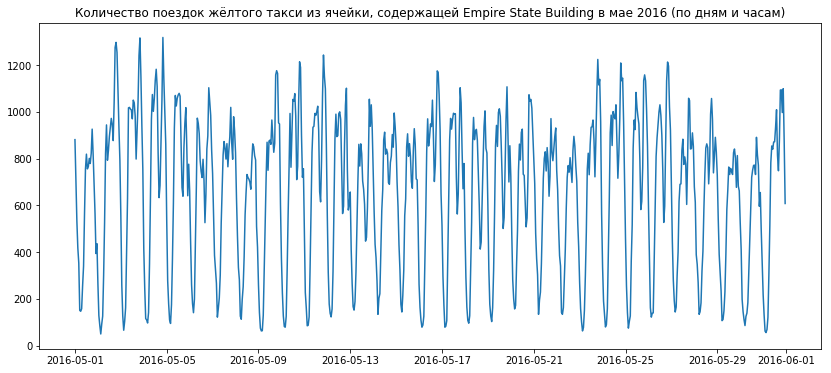

In [169]:
plt.figure(figsize=(14,6))
plt.title('Количество поездок жёлтого такси из ячейки, содержащей Empire State Building в мае 2016 (по дням и часам)')
plt.plot(df_esb.date_hour,df_esb.trip)
plt.show()

На графике с почасовыми выездами - сложно что-то разглядеть, поэтому построим отдельные графики по дням и по часам:

In [170]:
df_esb['day'] = df_esb['date_hour'].apply(lambda d: pd.datetime(d.year,d.month,d.day))
df_esb['hour'] = df_esb['date_hour'].apply(lambda d: d.hour)

In [171]:
df_esb.head()

,date_hour,region,trip,day,hour
1230,2016-05-01 00:00:00,1231,881.0,2016-05-01,0
3730,2016-05-01 01:00:00,1231,713.0,2016-05-01,1
6230,2016-05-01 02:00:00,1231,533.0,2016-05-01,2
8730,2016-05-01 03:00:00,1231,418.0,2016-05-01,3
11230,2016-05-01 04:00:00,1231,353.0,2016-05-01,4


In [172]:
trips_by_day = df_esb.groupby('day')['trip'].sum()

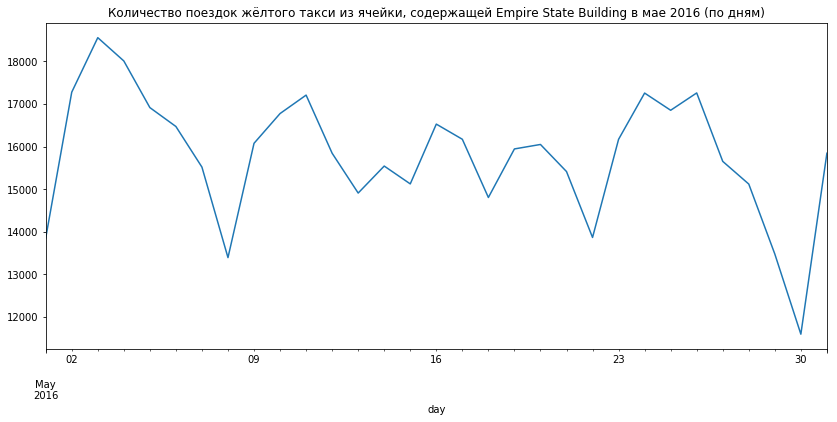

In [173]:
plt.figure(figsize=(14,6))
plt.title('Количество поездок жёлтого такси из ячейки, содержащей Empire State Building в мае 2016 (по дням)')
trips_by_day.plot()
plt.show()

И посмотрим количество поездок по часам

In [174]:
trips_by_hour = df_esb.groupby('hour')['trip'].sum()

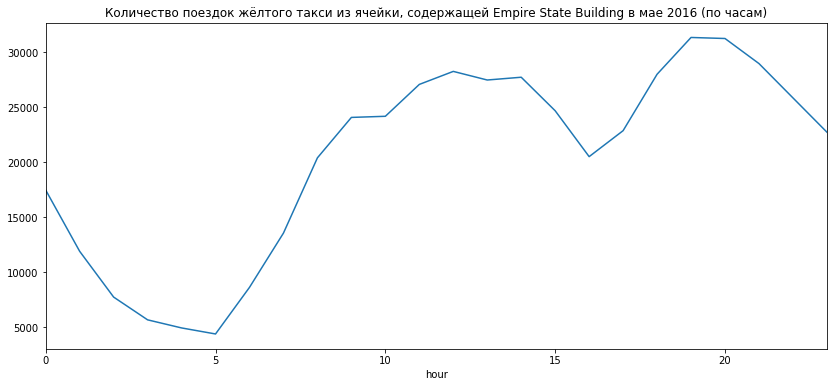

In [175]:
plt.figure(figsize=(14,6))
plt.title('Количество поездок жёлтого такси из ячейки, содержащей Empire State Building в мае 2016 (по часам)')
trips_by_hour.plot()
plt.show()

Меньше всего заказов - в 5 утра
Пик заказов - в районе 19-20 вечера

__6. Посчитайте, сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки.__

In [176]:
#Ответ:
len(df[df['trip']==0])

1718238